# Predicting Bike Rentals

Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Here are the descriptions for the relevant columns:

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)

In this project, you'll try to predict the total number of bikes people rented in a given hour. You'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, you'll create a few different machine learning models and evaluate their performance.



In [1]:
import pandas as pd

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')

In [3]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [6]:
xticks = list(range(0,1100,100))
print(xticks)

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]


<AxesSubplot:ylabel='Frequency'>

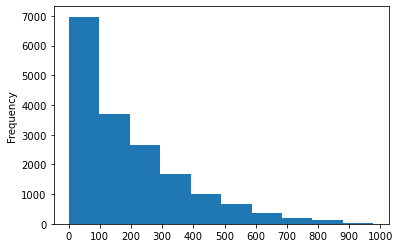

In [7]:
bike_rentals['cnt'].plot(kind='hist', xticks=xticks)

We can see that the most common outcome is that fewer than 100 bikes are rented. In general, it is increasingly less common for high amounts of bikes to be rented.

In [9]:
corrs = bike_rentals.corr()
cnt_corr = abs(corrs['cnt']).sort_values(ascending=False)
print(cnt_corr)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64


Not surprisingly, the number of registered rentals is by far the best predictor, as that is a key part of total rentals. The same goes for casual rentals. Because these two add up to the total rentals, we should not use them for predictive purposes. Instead we'll use the other useful features, such as temperature, hour of the day, and humidity.

Let's see what effects the individual components of total rentals, registered and casual.

In [26]:
reg_corr = abs(corrs['registered']).sort_values(ascending=False)
print(reg_corr)

registered    1.000000
cnt           0.972151
casual        0.506618
hr            0.374141
temp          0.335361
atemp         0.332559
instant       0.282046
hum           0.273933
yr            0.253684
season        0.174226
workingday    0.134326
mnth          0.122273
weathersit    0.120966
windspeed     0.082321
holiday       0.047345
weekday       0.021578
Name: registered, dtype: float64


In [27]:
cas_corr = abs(corrs['casual']).sort_values(ascending=False)
print(cas_corr)

casual        1.000000
cnt           0.694564
registered    0.506618
temp          0.459616
atemp         0.454080
hum           0.347028
hr            0.301202
workingday    0.300942
instant       0.158295
weathersit    0.152628
yr            0.142779
season        0.120206
windspeed     0.090287
mnth          0.068457
weekday       0.032721
holiday       0.031564
Name: casual, dtype: float64


For hour, let's group it into broader times of day.

In [10]:
def assign_label(hour):
    if 6 <= hour < 12:
        return 1
    elif 12 <= hour < 18:
        return 2
    elif 18 <= hour < 24:
        return 3
    else:
        return 4

<AxesSubplot:ylabel='Frequency'>

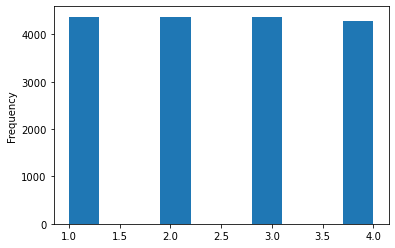

In [13]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals['time_label'].plot(kind='hist')

In [15]:
bike_rentals['time_label'].value_counts()

2    4375
3    4368
1    4360
4    4276
Name: time_label, dtype: int64

Looks like our hours are split pretty evenly. This makes sense if each day is recorded in full.

## Creating Training And Testing A Linear Regression Model

First we'll need to identify which columns to use. Let's use the features that were above .05 in the correlation, but make sure not to include the ones that add into the total.

In [52]:
features = cnt_corr.index[3:16].to_list()
print(features)

['temp', 'atemp', 'hr', 'hum', 'instant', 'yr', 'season', 'weathersit', 'mnth', 'windspeed', 'holiday', 'workingday', 'weekday']


One small problem is some of these may be intensely correlated with each other, like temp and atemp likely are. We don't want this, as it would inadvertently overweigh one aspect of the features. Let's check for this.

In [19]:
import seaborn as sns

In [53]:
feature_corr = bike_rentals[features].corr()
feature_corr

,temp,atemp,hr,hum,instant,yr,season,weathersit,mnth,windspeed,holiday,workingday,weekday
temp,1.000000,0.987672,0.137603,-0.069881,0.136178,0.040913,0.312025,-0.102640,0.201691,-0.023125,-0.027340,0.055390,-0.001795
atemp,0.987672,1.000000,0.133750,-0.051918,0.137615,0.039222,0.319380,-0.105563,0.208096,-0.062336,-0.030973,0.054667,-0.008821
hr,0.137603,0.133750,1.000000,-0.276498,-0.004775,-0.003867,-0.006117,-0.020203,-0.005772,0.137252,0.000479,0.002285,-0.003498
hum,-0.069881,-0.051918,-0.276498,1.000000,0.009577,-0.083546,0.150625,0.418130,0.164411,-0.290105,-0.010588,0.015688,-0.037158
instant,0.136178,0.137615,-0.004775,0.009577,1.000000,0.866014,0.404046,-0.014198,0.489164,-0.074505,0.014723,-0.003416,0.001357
yr,0.040913,0.039222,-0.003867,-0.083546,0.866014,1.000000,-0.010742,-0.019157,-0.010473,-0.008740,0.006692,-0.002196,-0.004485
season,0.312025,0.319380,-0.006117,0.150625,0.404046,-0.010742,1.000000,-0.014524,0.830386,-0.149773,-0.009585,0.013743,-0.002335
weathersit,-0.102640,-0.105563,-0.020203,0.418130,-0.014198,-0.019157,-0.014524,1.000000,0.005400,0.026226,-0.017036,0.044672,0.003311
mnth,0.201691,0.208096,-0.005772,0.164411,0.489164,-0.010473,0.830386,0.005400,1.000000,-0.135386,0.018430,-0.003477,0.010400
windspeed,-0.023125,-0.062336,0.137252,-0.290105,-0.074505,-0.008740,-0.149773,0.026226,-0.135386,1.000000,0.003988,-0.011830,0.011502


<AxesSubplot:>

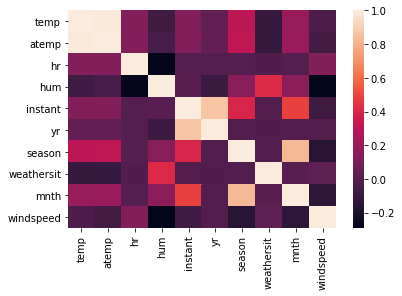

In [35]:
sns.heatmap(feature_corr)

We can see temp and atemp are completely correlated, so we'll definitely remove one of those. We can also see that instant, the ID column, is fairly correlated with yr, or the year column. This makes sense, as these are logged chronologically. For this reason, and because ID is somewhat arbitrary, we'll take out the instant column as well. Season is also fairly correlated with month. Since season is more closely correlated with our target of total rentals, we'll remove month.

In [54]:
features.remove('atemp')
features.remove('instant')
features.remove('mnth')
features

['temp',
 'hr',
 'hum',
 'yr',
 'season',
 'weathersit',
 'windspeed',
 'holiday',
 'workingday',
 'weekday']

Now we've got our 7 most relevant features. Temperature, hour, humidity, and year.

In [55]:
X = bike_rentals[features]
X.head()

,temp,hr,hum,yr,season,weathersit,windspeed,holiday,workingday,weekday
0,0.24,0,0.81,0,1,1,0.0,0,0,6
1,0.22,1,0.80,0,1,1,0.0,0,0,6
2,0.22,2,0.80,0,1,1,0.0,0,0,6
3,0.24,3,0.75,0,1,1,0.0,0,0,6
4,0.24,4,0.75,0,1,1,0.0,0,0,6


In [56]:
y = bike_rentals['cnt']
y.head()

0    16
1    40
2    32
3    13
4     1
Name: cnt, dtype: int64

In [16]:
from sklearn.model_selection import train_test_split

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [58]:
X_train.shape

(13903, 10)

In [59]:
X_test.shape

(3476, 10)

In [60]:
y_train.shape

(13903,)

In [61]:
y_test.shape

(3476,)

In [45]:
from sklearn.linear_model import LinearRegression

In [62]:
reg = LinearRegression()

In [63]:
reg.fit(X_train, y_train)

LinearRegression()

In [64]:
predictions = reg.predict(X_test)

In [49]:
from sklearn.metrics import mean_squared_error

In [65]:
mse = mean_squared_error(predictions, y_test)
rmse = mse**.5
print(mse)
print(rmse)

19971.14135564152
141.31928868927102


This is a very high error. This is basically saying that on average our predictions were off by about 141 bikes. Keep in mind the most common occurrence is for fewer than 100 bikes to be rented.

## Using a Decision Tree Regression Model

In [66]:
from sklearn.tree import DecisionTreeRegressor

In [67]:
tree = DecisionTreeRegressor()

In [68]:
tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [69]:
tree_predictions = tree.predict(X_test)

In [70]:
tree_mse = mean_squared_error(tree_predictions, y_test)
tree_rmse = tree_mse**.5
print(tree_mse)
print(tree_rmse)

3578.911104718067
59.824001075806244


This is way more accurate!

Let's see what happens if we try to adjust some of the parameters.

In [71]:
tree = DecisionTreeRegressor(min_samples_split = 10)
tree.fit(X_train, y_train)
tree_predictions = tree.predict(X_test)
tree_mse = mean_squared_error(tree_predictions, y_test)
tree_rmse = tree_mse**.5
print(tree_mse)
print(tree_rmse)

2887.652107889836
53.73687847177054


A little better still! Let's try some other parameter adjustments.

In [93]:
tree = DecisionTreeRegressor(min_samples_leaf = 10)
tree.fit(X_train, y_train)
tree_predictions = tree.predict(X_test)
tree_mse = mean_squared_error(tree_predictions, y_test)
tree_rmse = tree_mse**.5
print(tree_mse)
print(tree_rmse)

2613.7372570281295
51.12472256186951


From a little testing, looks like this is about as good a prediction as we can get.

## Random Forest

In [94]:
from sklearn.ensemble import RandomForestRegressor

In [101]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train)
forest_predictions = forest.predict(X_test)
forest_mse = mean_squared_error(forest_predictions, y_test)
forest_rmse = forest_mse**.5
print(forest_mse)
print(forest_rmse)

1800.1022087163064
42.427611395367364


With no parameter optimization, our forest still does better than the decision tree regressor, and much better than the linear regressor. Let's try to optimize parameters and improve accuracy even more.

In [111]:
forest = RandomForestRegressor(max_features = 6)
forest.fit(X_train, y_train)
forest_predictions = forest.predict(X_test)
forest_mse = mean_squared_error(forest_predictions, y_test)
forest_rmse = forest_mse**.5
print(forest_mse)
print(forest_rmse)

1749.109590712112
41.82235754607949


After trying a number of parameter optimizations, the best I could do was by limiting the amount of features selected to 6, which made the forest marginally better at predicting results.